In [1]:
# Peter Karras 2020
''' Contains the Custom Dataset creation and the CNN
    NOTE: MUST HAVE FILE FROM MAKEMASTER PROGRAM PRIOR TO RUNNING'''

' Contains the Custom Dataset creation and the CNN\n    NOTE: MUST HAVE FILE FROM MAKEMASTER PROGRAM PRIOR TO RUNNING'

In [2]:
#Time: 401.0922603607178s for 10,000 files
#max is: 43.8977567043499
#max is: 22.0574247607658
# Time: 153.2100191116333 for 4,000 files
# max is: 40.046902918943
# max is: 22.0574247607658
# Time: 98.4042558670044 for 2,500 files
# max is: 40.508388402478
# min is: 24.8413349715329
# Time: 33.11633038520813 for 933 files
# max is: 40.3920694022969
# min is: 24.8413349715329
# Time: for 9000 files
# max is: 43.85429664867971
# min is: 21.584069668121902

# FULL 55000
#Time taken (s): 45913.3
#Max value is: 43.8977567043499
#Min value is: 21.584069668121902

# March
#Time: 187.95090889930725
#max is: 40.342822540551296
#min is: 22.0574247607658
# April
# Time: 286.47614312171936
# max is: 43.8977567043499
# min is: 23.0867814341884
# May
# Time: 355.6945369243622
# max is: 41.651975331159896
# min is: 22.549667363426103
# June
# Time: 258.5124309062958
# max is: 42.1865665374543
# min is: 24.2563848704595
# July
# Time: 117.10082149505615
# max is: 40.3920694022969
# min is: 23.3752163703192
# August
# Time: 167.5036985874176
# max is: 40.1815051816256
# min is: 22.1157735577469
# Sep
# Time: 252.0023398399353
# max is: 43.200494433666
# min is: 21.9034323541466
# Morn
# Time: 542.1251473999982
# max is: 43.8977567043499
# min is: 22.0574247607658
# Afternoon
# Time: 136.8002856000021
# max is: 43.235454379802796
# min is: 22.014967836717897
# Night 2-9
#Time: 655.5211607999954
#max is: 40.432346810251296
#min is: 21.584069668121902
# DAytime
#Time: 1074.7459823999998
#max is: 43.8977567043499
#min is: 21.584069668121902
"""
epochinfotime
"""
# 3batchsize Epochs for 55,000 take 1446 s per epoch
# Epochs for 10,000 files take 280 s per epoch
# Epochs for 4,000 files take 101 s per epoch
# Epochs for 2,500 files take 65 s per epoch
# Epochs for 933 files take 24 s per epoch

""" 
EPOCH TIME CALC
"""
fileSize = 28572
minutesToTrain = 60 * 15

secondsPerEpoch = (0.0287*(fileSize) - 6.4268)
secondsToTrain = minutesToTrain * 60.0
epochsToUse = secondsToTrain/secondsPerEpoch
print("To train for", minutesToTrain, "minutes use", epochsToUse, "epochs") 

To train for 900 minutes use 66.37252983568128 epochs


In [3]:
""" IMPORT NEEDED MODULES """

import pandas as pd
import os
import sys
import csv
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt

import time
from datetime import datetime

import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

import torch.optim as optim
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data.dataset import Dataset  # For custom datasets

In [4]:
# Issues with directories, use this to reset cwd and then move into desired directory 
#os.chdir("/content")
startingDir = os.getcwd()
if startingDir != r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new2/":
    startingDir = r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new2/"
print(startingDir)
csvfilesMLLocation = r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new2/csvdataFULL/BCIML_Dataset"
baseSaveLocation = r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new/BCI-ML/Monthly_Data_Summaries_csv"

C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new2/


In [10]:
""" CREATE CUSTOM DATASET """
# Pulls from pool of 900 thermal images
class BCIDataset2(Dataset):
    def __init__(self, csv_master_path, transform=None):
        """
        Args:
            csv_master_path (string): path to csv file with thermal image (csv's) file paths
            as first column and GPP values as the second column, rows are one set of
            correlating data points
            transform (callable, optional): Optional transform to be applied on a sample
        """
        # Transforms
        self.to_tensor = transforms.ToTensor()
        # Read the csv file 
        #self.data_info = pd.read_csv(csv_master_path, header=None)
        self.data_info = pd.read_csv(csv_master_path)
        # First column contains thermal image (csv's) file paths
        self.thermal_path_arr = np.asarray(self.data_info.iloc[:,0])
        # Second column is the GPP values for the images from first column
        self.GPP_arr = np.asarray(self.data_info.iloc[:,1])        
        self.transform = transforms.ToTensor()
        max_list = np.full(1,-10)
        min_list = np.full(1, 99999)
        os.chdir(csvfilesMLLocation)
        start = time.perf_counter()
        for filename in self.thermal_path_arr:
            file_temps = pd.read_csv(filename)
            file_temps_vals = file_temps.values
            torch_temps = torch.from_numpy(file_temps_vals)
            max_list = np.append(max_list, [torch.max(torch_temps)])
            min_list = np.append(min_list, [torch.min(torch_temps)])
        self.ABS_MAX = (torch.max(torch.from_numpy(max_list))).item()
        self.ABS_MIN = (torch.min(torch.from_numpy(min_list))).item()
#         self.ABS_MAX = 40.432346810251296
#         self.ABS_MIN = 21.584069668121902
        print(f'Time: {time.perf_counter()-start}')
        print("max is:", self.ABS_MAX)
        print("min is:", self.ABS_MIN)
            
        
    #NOTE: might need to flip image
    def __getitem__(self, index):
        # Get thermal image (csv) path
        single_thermal_path = self.thermal_path_arr[index]
        # Convert csv to pandas dataframe
        pd_thermal_img = pd.read_csv(single_thermal_path)
        # Convert pandas dataframe to numpy array
        ###np_thermal_img = np.asarray(pd_thermal_img.iloc[:,1:])
        np_thermal_img = np.asarray(pd_thermal_img)
        # Normalization of values from orignal csv file, translates thermal values to 0-1 range
        # https://stats.stackexchange.com/questions/70801/how-to-normalize-data-to-0-1-range
        np_normalized_temp_no_channel = ((np_thermal_img-self.ABS_MIN)/(self.ABS_MAX - self.ABS_MIN))
        # Flip image by 90 degrees, is commented out currently as might mess with network architecture
        #np_thermal_img = np.rot90(np_thermal_img)
        # Add num channels dimension and format correctly
        np_normalized_temp = np.expand_dims(np_normalized_temp_no_channel, axis=0)
        # Transform numpy array to tensor
        tensor_normal_thermal_vals = torch.from_numpy(np_normalized_temp)
        # Get GPP value for image
        single_image_GPP = self.GPP_arr[index]
        return(tensor_normal_thermal_vals, single_image_GPP)
    
    def __len__(self):
        return len(self.data_info)

In [11]:
"""Working network"""
class BCIModel(nn.Module):
    def __init__(self):
        super(BCIModel, self).__init__()
        # Convulutional Layer 1 (sees 320 x 240 x 1 image tensor)
        self.conv1 = nn.Conv2d(1, 16, 3, padding = 1)
        # Convulutional Layer 2 (sees 160 x 120 x 16 image tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        # Convulutional Layer 3 (sees 80 x 60 x 32 tensor, reduced height and width from max pooling layer and stride=2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
        # Convulutional Layer 4 (sees 40 x 30 x 64 tensor, reduced height and width from max pooling layer and stride=2)
        self.conv4 = nn.Conv2d(64, 128, 3, padding = 1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(2,2)
        # Linear and Batchnorm Layers
        self.fc1 = nn.Linear(128 * 20 * 15, 100)
        self.BatchN = nn.BatchNorm1d(100)
        self.fc2 = nn.Linear(100, 1)
        
        # Dropout Layer
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        # Add sequence of convulutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 128 * 20 * 15)
        # Add dropout layer
        x = self.dropout(x)
        # Add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # Add dropout layer
        x = self.dropout(x)
        # Add last layer
        x = (self.fc2(x))
        return x

Time: 1074.7459823999998
max is: 43.8977567043499
min is: 21.584069668121902
BCIModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=38400, out_features=100, bias=True)
  (BatchN): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=100, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)
CUDA is available!  Training on GPU ...
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
GeForce RTX 2070 SUPER
Memory Usage:
Allocated: 0.0 GB
Cached:    0.1 GB
Epoch #: 1
Epoch: 1 	Training Loss: 66.123866 

Epoch: 44 	Training Loss: 17.332963 	Validation Loss: 16.919686
Validation loss decreased (16.996186 --> 16.919686).  Saving model ...
Time: 748.0403753999999
Current Time = 10:48:01
LR: 0.0009223681599999998
Epoch #: 45
Epoch: 45 	Training Loss: 17.493462 	Validation Loss: 16.777689
Validation loss decreased (16.919686 --> 16.777689).  Saving model ...
Time: 821.8495392000041
Current Time = 11:01:42
LR: 0.0009039207967999998
Epoch #: 46
Epoch: 46 	Training Loss: 16.996265 	Validation Loss: 16.813586
Time: 886.2470229999963
Current Time = 11:16:29
LR: 0.0008858423808639998
Epoch #: 47
Epoch: 47 	Training Loss: 16.622409 	Validation Loss: 16.022410
Validation loss decreased (16.777689 --> 16.022410).  Saving model ...
Time: 868.750544399998
Current Time = 11:30:58
LR: 0.0008681255332467198
Epoch #: 48
Epoch: 48 	Training Loss: 16.691095 	Validation Loss: 16.508743
Time: 879.8052575999973
Current Time = 11:45:37
LR: 0.0008507630225817853
Epoch #: 49
Epoch: 49 	Training Loss: 16.022177 	V

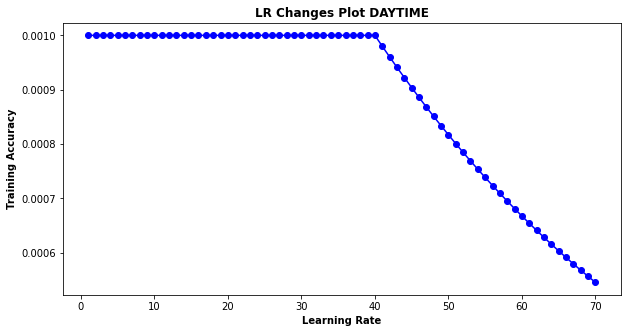

<Figure size 1080x72 with 0 Axes>

test loss from 0 : 6.81553840637207
Output of network:	 tensor([24.2446,  9.5035,  5.1724, 14.3371,  1.8778, 17.5573], device='cuda:0')
Target Values:		 tensor([24.3090, 15.3287,  6.2493, 13.1395,  0.3723, 16.1095], device='cuda:0') 

loss from this run: 6.81553840637207
Output 1 : 24.244617462158203
Output 2 : 9.50346851348877
Output 3 : 5.172427177429199
Output 4 : 14.337050437927246
Output 6 : 17.557270050048828
Target 1 : 24.309017181396484
Target 2 : 15.328653335571289
Target 3 : 6.249279499053955
Target 4 : 13.139487266540527
Target 6 : 16.109506607055664
test loss from 1 : 19.870792388916016
Output of network:	 tensor([ 1.1341, 10.7528, 11.3495, 32.2902, 20.5060, 28.1443], device='cuda:0')
Target Values:		 tensor([ 0.0000, 14.5903, 11.9123, 26.2209, 21.8064, 20.1214], device='cuda:0') 

loss from this run: 19.870792388916016
Output 2 : 10.752765655517578
Output 3 : 11.34951400756836
Output 4 : 32.29023742675781
Output 5 : 20.506000518798828
Output 6 : 28.144275665283203
Target 2

Target Values:		 tensor([ 0.0000, 28.1755,  0.6625, 28.8448,  0.0000, 11.2257], device='cuda:0') 

test loss from 2 : 4.462373733520508
Output of network:	 tensor([13.8702,  1.9382, 24.9345,  1.1346,  1.7172, 22.5422], device='cuda:0')
Target Values:		 tensor([15.9429,  0.0000, 24.0726,  0.0000,  0.0000, 26.2494], device='cuda:0') 

test loss from 2 : 5.871856689453125
Output of network:	 tensor([ 6.8050,  1.1341, 11.9589,  1.4830, 31.0368, 35.2133], device='cuda:0')
Target Values:		 tensor([ 6.0224,  0.0000, 14.2559,  0.0000, 30.7945, 30.1341], device='cuda:0') 

test loss from 2 : 26.990432739257812
Output of network:	 tensor([16.1772,  1.1341, 23.9348, 26.0325, 15.9388, 24.7092], device='cuda:0')
Target Values:		 tensor([17.6267,  0.0000, 27.2406, 26.1588,  7.2325, 33.1834], device='cuda:0') 

test loss from 2 : 1.857715129852295
Output of network:	 tensor([39.4944, 18.1115,  2.2539, 16.0123,  6.9639,  1.1341], device='cuda:0')
Target Values:		 tensor([39.0960, 17.8336,  0.0000, 18.

Output of network:	 tensor([ 1.1341, 25.0691, 25.3035,  1.1341, 10.0426,  1.1341], device='cuda:0')
Target Values:		 tensor([ 0.0000, 28.0411, 22.0940,  0.0000,  7.8089,  0.0000], device='cuda:0') 

test loss from 2 : 7.873038291931152
Output of network:	 tensor([ 2.1739, 12.7861,  1.1341, 24.4925, 20.4268,  1.8072], device='cuda:0')
Target Values:		 tensor([ 0.4444, 11.5188,  0.5381, 23.4025, 14.2760,  0.0000], device='cuda:0') 

test loss from 2 : 2.7536001205444336
Output of network:	 tensor([11.4728,  1.3693, 19.9833,  5.5085, 31.0219,  1.1696], device='cuda:0')
Target Values:		 tensor([11.1943,  0.0000, 20.3564,  4.4526, 34.4783,  0.0000], device='cuda:0') 

test loss from 2 : 3.2405600547790527
Output of network:	 tensor([1.1341, 1.1341, 2.6292, 2.4480, 1.6369, 1.1341], device='cuda:0')
Target Values:		 tensor([0., 0., 0., 0., 0., 0.], device='cuda:0') 

test loss from 2 : 3.6455228328704834
Output of network:	 tensor([ 2.6027,  8.8910, 27.5922,  1.4204,  1.1341,  1.1341], device

Target Values:		 tensor([ 0.0000, 29.2288, 20.9989,  0.0000, 15.5667, 17.5461], device='cuda:0') 

test loss from 2 : 27.104259490966797
Output of network:	 tensor([ 6.9573,  1.5273, 27.9537, 23.7517,  1.1423, 12.8767], device='cuda:0')
Target Values:		 tensor([ 1.1329,  0.0000, 34.3935, 15.2146,  0.0000,  9.6038], device='cuda:0') 

test loss from 2 : 6.2924957275390625
Output of network:	 tensor([ 2.0785,  6.0492,  4.0908, 27.7280, 16.0059, 10.0099], device='cuda:0')
Target Values:		 tensor([ 0.0000,  5.4432,  0.0000, 30.7900, 15.1979, 12.5208], device='cuda:0') 

test loss from 2 : 7.646321773529053
Output of network:	 tensor([ 4.1419, 11.9574, 23.8938,  5.7499,  8.8977, 32.5294], device='cuda:0')
Target Values:		 tensor([ 2.4532, 11.3720, 28.6833,  6.6392,  4.6465, 31.5909], device='cuda:0') 

test loss from 2 : 2.392946481704712
Output of network:	 tensor([ 1.1341,  1.1341, 29.8615,  1.3645, 25.0226, 15.2259], device='cuda:0')
Target Values:		 tensor([ 0.0000,  0.0000, 27.2602,  2

Output of network:	 tensor([ 8.5225,  1.4887, 22.1310, 18.2509, 26.4581, 11.9714], device='cuda:0')
Target Values:		 tensor([ 8.2136,  0.0000, 21.8395, 22.5954, 29.0709,  9.8981], device='cuda:0') 

test loss from 2 : 8.38945198059082
Output of network:	 tensor([17.6962,  1.1341,  5.2827,  3.8586,  1.1390,  1.9727], device='cuda:0')
Target Values:		 tensor([14.9258,  0.0000,  9.8976,  0.0000,  0.0000,  0.0000], device='cuda:0') 

test loss from 2 : 4.01657772064209
Output of network:	 tensor([ 1.1341,  4.1368, 24.1363,  1.6505, 19.8854, 10.0823], device='cuda:0')
Target Values:		 tensor([ 0.0000,  0.5211, 23.4653,  1.7327, 18.6743, 12.8780], device='cuda:0') 

test loss from 2 : 2.8732924461364746
Output of network:	 tensor([ 1.1341,  2.6624,  1.1341, 22.9877,  1.1341, 18.8340], device='cuda:0')
Target Values:		 tensor([ 0.0000,  0.0000,  0.0000, 21.9842,  0.0000, 21.1329], device='cuda:0') 

test loss from 2 : 23.06801986694336
Output of network:	 tensor([28.7407,  2.8623,  1.5911, 26

Target Values:		 tensor([ 2.1071, 30.1133, 12.9368, 46.8273, 17.6605,  0.0000], device='cuda:0') 

test loss from 2 : 4.627283096313477
Output of network:	 tensor([ 1.5192, 20.0614, 20.7569,  1.7310, 14.7156, 31.7214], device='cuda:0')
Target Values:		 tensor([ 0.0000, 23.0593, 17.1822,  1.1828, 14.6556, 29.8814], device='cuda:0') 

test loss from 2 : 82.30036926269531
Output of network:	 tensor([ 1.6478,  1.9998,  3.4902, 16.6057, 28.9804,  7.7411], device='cuda:0')
Target Values:		 tensor([ 0.0000,  0.0000,  2.5945, 21.3861,  8.5541,  0.9441], device='cuda:0') 

test loss from 2 : 5.786921977996826
Output of network:	 tensor([ 1.2102, 13.2033,  1.1341,  1.1792, 18.2110, 17.8326], device='cuda:0')
Target Values:		 tensor([ 0.0000, 13.1832,  0.0000,  0.0000, 21.7969, 22.0423], device='cuda:0') 

test loss from 2 : 10.261360168457031
Output of network:	 tensor([29.7171,  1.1473, 16.8297,  1.2435, 28.2022, 22.4265], device='cuda:0')
Target Values:		 tensor([36.2841,  0.7292, 18.0793,  0.

Output of network:	 tensor([16.1400, 18.1979, 16.5815, 24.6854,  9.7542,  1.1341], device='cuda:0')
Target Values:		 tensor([19.5412, 17.2115, 15.4706, 23.0812, 13.0458,  0.0000], device='cuda:0') 

test loss from 2 : 63.546722412109375
Output of network:	 tensor([ 6.2667,  1.8875,  5.2759, 23.0215, 27.1051, 27.7278], device='cuda:0')
Target Values:		 tensor([14.4352,  0.0000, 19.3868, 31.9710, 30.1372, 32.4803], device='cuda:0') 

test loss from 2 : 17.11114501953125
Output of network:	 tensor([18.4606, 10.4174, 21.1562, 21.6892,  1.1341, 21.4526], device='cuda:0')
Target Values:		 tensor([20.4714, 17.5491, 24.3930, 15.6938,  0.0000, 21.2184], device='cuda:0') 

test loss from 2 : 15.377252578735352
Output of network:	 tensor([ 8.8186, 20.9258, 13.5137, 28.1799, 13.6632,  1.6922], device='cuda:0')
Target Values:		 tensor([10.4314, 22.3292, 18.7055, 35.7870, 13.7405,  0.0000], device='cuda:0') 

test loss from 2 : 4.532047748565674
Output of network:	 tensor([10.9884,  1.9365, 23.5430,

Target Values:		 tensor([19.6754, 26.9844,  0.0000,  3.5194, 20.1185, 29.1770], device='cuda:0') 

test loss from 2 : 10.872833251953125
Output of network:	 tensor([ 1.1447,  8.0329, 19.6767,  2.4364, 16.4757, 14.9030], device='cuda:0')
Target Values:		 tensor([ 2.5500,  6.5407, 14.6970,  5.1028, 18.5463,  9.9190], device='cuda:0') 

test loss from 2 : 10.411489486694336
Output of network:	 tensor([ 6.7813,  1.1341, 16.1185,  1.1341,  1.7344, 26.3523], device='cuda:0')
Target Values:		 tensor([ 1.0628,  0.0000, 11.6447,  0.0000,  4.1411, 27.5304], device='cuda:0') 

test loss from 2 : 31.493534088134766
Output of network:	 tensor([ 1.8573,  4.4937,  6.8492, 20.0216,  1.1341,  1.4007], device='cuda:0')
Target Values:		 tensor([ 0.0000,  0.5435, 19.6322, 18.2175,  0.0000,  0.0000], device='cuda:0') 

test loss from 2 : 5.161230087280273
Output of network:	 tensor([ 3.6616, 24.5285,  2.1897,  1.1341,  1.7235, 17.3993], device='cuda:0')
Target Values:		 tensor([ 2.7940, 28.1600,  0.0000,  

Output of network:	 tensor([ 2.7049, 24.4735, 13.6344,  2.7664, 14.2110,  9.1997], device='cuda:0')
Target Values:		 tensor([ 0.0000, 26.4020,  6.4071,  2.3181, 12.6374,  2.5750], device='cuda:0') 

test loss from 2 : 4.508729934692383
Output of network:	 tensor([14.2474,  4.2788,  7.1666,  1.8188,  8.1097, 28.6666], device='cuda:0')
Target Values:		 tensor([11.6449,  2.4093,  4.3030,  0.0000,  6.1740, 27.4300], device='cuda:0') 

test loss from 2 : 7.220365524291992
Output of network:	 tensor([17.8289, 10.7204,  1.1341,  1.1341,  1.1615,  1.1341], device='cuda:0')
Target Values:		 tensor([20.7286,  5.7474,  0.0000,  0.0000,  3.8947,  0.7601], device='cuda:0') 

test loss from 2 : 6.253939628601074
Output of network:	 tensor([ 1.3760, 18.7886,  1.3534, 19.1458, 19.5114, 16.8797], device='cuda:0')
Target Values:		 tensor([ 0.0000, 13.7386,  0.0000, 17.2151, 19.3472, 19.0107], device='cuda:0') 

test loss from 2 : 7.774097442626953
Output of network:	 tensor([ 2.6701, 24.0908,  4.8481, 2

Target Values:		 tensor([ 1.6386, 14.6601,  8.7689, 26.8792, 16.7053, 13.9859], device='cuda:0') 

test loss from 2 : 3.2348198890686035
Output of network:	 tensor([18.2231,  1.7465,  2.4409, 17.5439,  8.4669, 19.9234], device='cuda:0')
Target Values:		 tensor([19.4270,  1.2395,  0.0000, 14.6139,  8.7911, 18.1757], device='cuda:0') 

test loss from 2 : 22.532737731933594
Output of network:	 tensor([21.2487, 20.3258,  1.1513,  1.1341,  8.5350, 21.7124], device='cuda:0')
Target Values:		 tensor([25.2937, 20.1506,  0.0000,  0.0000, 11.9264, 31.9442], device='cuda:0') 

test loss from 2 : 6.469240188598633
Output of network:	 tensor([19.1548,  8.0036,  1.2096,  1.2306, 12.0447,  2.2674], device='cuda:0')
Target Values:		 tensor([23.9649,  8.5881,  0.0000,  0.0000, 14.7316,  0.0000], device='cuda:0') 

test loss from 2 : 27.56191062927246
Output of network:	 tensor([19.5387, 16.4404, 30.6440, 24.2576, 16.8602, 29.7569], device='cuda:0')
Target Values:		 tensor([16.5352, 14.2188, 31.8423, 13

Output of network:	 tensor([15.0078,  1.3152, 14.2705, 19.6997,  1.7846, 21.8748], device='cuda:0')
Target Values:		 tensor([13.0822,  2.9147, 18.1391, 20.9379,  0.0000, 21.0245], device='cuda:0') 

test loss from 2 : 14.991598129272461
Output of network:	 tensor([16.5310, 23.9797, 20.2323, 15.1789, 19.8786, 11.4977], device='cuda:0')
Target Values:		 tensor([23.4863, 21.4263, 18.9269, 13.7867, 25.2853, 12.9737], device='cuda:0') 

test loss from 2 : 11.374563217163086
Output of network:	 tensor([ 2.4815,  4.2812, 24.1620, 13.6793, 12.5758,  5.2989], device='cuda:0')
Target Values:		 tensor([ 4.1143,  2.3662, 29.8192, 12.6636, 13.4708,  0.0000], device='cuda:0') 

test loss from 2 : 4.649774074554443
Output of network:	 tensor([ 1.2381,  1.6662,  6.2674, 19.2524,  2.3884,  1.5418], device='cuda:0')
Target Values:		 tensor([ 0.0000,  0.0000,  4.5241, 21.5867,  0.1824,  4.7411], device='cuda:0') 

test loss from 2 : 9.678694725036621
Output of network:	 tensor([5.2539, 7.8722, 6.3591, 1.

Target Values:		 tensor([19.5879, 22.1730,  1.5812,  4.5717,  0.0000, 12.8878], device='cuda:0') 

test loss from 2 : 25.890335083007812
Output of network:	 tensor([14.0301, 16.5137, 11.6828,  9.6653,  2.0410,  2.6340], device='cuda:0')
Target Values:		 tensor([16.3912,  9.7447, 12.3828, 19.6262,  0.0000,  2.9047], device='cuda:0') 

test loss from 2 : 2.9700021743774414
Output of network:	 tensor([ 1.2981, 13.0298, 19.3424, 31.8706, 32.3190,  1.2089], device='cuda:0')
Target Values:		 tensor([ 0.0000, 13.6171, 20.3757, 32.0534, 35.9560,  0.0000], device='cuda:0') 

test loss from 2 : 3.402437210083008
Output of network:	 tensor([ 1.1341,  1.3026,  3.5851, 27.0636, 28.6381, 23.1342], device='cuda:0')
Target Values:		 tensor([ 0.0000,  1.8988,  0.3926, 26.1438, 27.6596, 20.5309], device='cuda:0') 

test loss from 2 : 6.667806148529053
Output of network:	 tensor([19.0995, 20.8674,  1.1341, 17.8117, 19.4327,  5.4459], device='cuda:0')
Target Values:		 tensor([23.9658, 21.6680,  0.0000, 15

Output of network:	 tensor([15.8656, 11.3279, 21.6193,  1.2639, 27.5317,  1.1341], device='cuda:0')
Target Values:		 tensor([13.6514,  3.0783, 20.0605,  0.7619, 29.4594,  0.0000], device='cuda:0') 

test loss from 2 : 20.71915054321289
Output of network:	 tensor([26.2584, 18.8018,  2.6133, 16.9673,  1.1341,  1.1341], device='cuda:0')
Target Values:		 tensor([18.6864, 20.5520,  0.0000,  9.5839,  0.0000,  0.0000], device='cuda:0') 

test loss from 2 : 12.5941162109375
Output of network:	 tensor([ 1.3569, 21.1831,  8.5680,  1.1341, 25.0270, 20.1278], device='cuda:0')
Target Values:		 tensor([ 0.0000, 26.4059,  9.6866,  0.0000, 31.1368, 22.6926], device='cuda:0') 

test loss from 2 : 45.292701721191406
Output of network:	 tensor([ 5.8471, 23.0023, 26.5082,  1.5643,  1.7124,  5.5292], device='cuda:0')
Target Values:		 tensor([20.1685, 26.6621, 33.3273,  0.0000,  3.3649,  6.7867], device='cuda:0') 

test loss from 2 : 6.814522743225098
Output of network:	 tensor([ 1.1841, 29.8287, 11.4878,  

Target Values:		 tensor([ 8.1864,  0.0000, 28.0560, 23.0145, 23.9264,  6.0486], device='cuda:0') 

test loss from 2 : 13.851324081420898
Output of network:	 tensor([15.4988,  5.9926,  4.8399, 23.0173,  2.3117, 18.6894], device='cuda:0')
Target Values:		 tensor([16.8139,  8.2902, 13.0768, 23.1358,  0.0000, 20.3907], device='cuda:0') 

test loss from 2 : 8.721847534179688
Output of network:	 tensor([ 2.1445,  3.3487, 16.9109, 16.3971,  1.5202, 27.4964], device='cuda:0')
Target Values:		 tensor([ 1.1287,  4.4687, 15.1103, 15.5512,  0.0000, 34.1128], device='cuda:0') 

test loss from 2 : 2.981093168258667
Output of network:	 tensor([ 1.1341, 18.5186, 26.5688, 19.8571, 30.2874,  1.1341], device='cuda:0')
Target Values:		 tensor([ 0.0000, 17.5378, 29.2348, 19.7584, 32.9772,  0.0000], device='cuda:0') 

test loss from 2 : 3.9314637184143066
Output of network:	 tensor([19.1283, 15.3273, 21.3319, 10.9294,  2.5819, 15.2083], device='cuda:0')
Target Values:		 tensor([20.7295, 16.5194, 23.5915, 13

Output of network:	 tensor([28.3420, 27.5540,  1.8392, 13.0849,  4.5212, 26.3533], device='cuda:0')
Target Values:		 tensor([25.1715, 25.5898,  0.0000, 14.6254,  1.0937, 17.4415], device='cuda:0') 

test loss from 2 : 1.3608274459838867
Output of network:	 tensor([ 1.8779,  2.9215,  2.4308,  2.3969,  8.0467, 17.0824], device='cuda:0')
Target Values:		 tensor([ 2.2855,  3.1852,  2.3049,  0.0000,  7.7003, 18.5136], device='cuda:0') 

test loss from 2 : 22.22287368774414
Output of network:	 tensor([ 8.3802, 21.0043, 13.9717,  1.3718, 21.9772, 35.6008], device='cuda:0')
Target Values:		 tensor([ 6.0892, 16.7312, 13.5909,  0.0000, 28.1842, 27.2776], device='cuda:0') 

test loss from 2 : 44.38948059082031
Output of network:	 tensor([22.8616,  4.7100,  1.1341, 10.5389, 22.8974, 13.1902], device='cuda:0')
Target Values:		 tensor([20.4281, 11.4917,  0.0000, 23.4211, 21.5750,  6.4495], device='cuda:0') 

test loss from 2 : 10.857481956481934
Output of network:	 tensor([ 2.2106, 17.5747, 21.8033,

Target Values:		 tensor([23.0826, 19.7769, 23.4339,  4.3843, 15.5219, 28.9012], device='cuda:0') 

test loss from 2 : 23.965734481811523
Output of network:	 tensor([ 1.1341, 18.8469, 28.2611, 25.1199, 17.6857,  1.1341], device='cuda:0')
Target Values:		 tensor([ 0.0000, 23.2443, 30.9318, 35.7334, 18.0805,  2.9331], device='cuda:0') 

test loss from 2 : 41.29665756225586
Output of network:	 tensor([25.3154, 18.8040, 13.6702, 21.9473,  3.2871, 18.3393], device='cuda:0')
Target Values:		 tensor([12.4348, 15.3173, 16.1733, 15.6235,  0.0000, 21.8961], device='cuda:0') 

test loss from 2 : 10.728861808776855
Output of network:	 tensor([ 1.5089,  2.6508,  7.1646,  1.1341, 24.4093,  1.7589], device='cuda:0')
Target Values:		 tensor([ 0.0000,  0.0000,  5.9545,  0.0000, 17.3932,  0.0000], device='cuda:0') 

test loss from 2 : 10.6009521484375
Output of network:	 tensor([ 1.6455, 27.5504, 23.1274, 11.9509, 29.8149,  1.4293], device='cuda:0')
Target Values:		 tensor([ 7.2828, 28.4400, 18.7958,  9.

Output of network:	 tensor([16.1487, 31.5304, 15.8250, 18.9056,  8.9159, 20.6278], device='cuda:0')
Target Values:		 tensor([19.1056, 34.6572, 16.1269, 15.7312, 10.0790, 14.3351], device='cuda:0') 

test loss from 2 : 15.061729431152344
Output of network:	 tensor([28.8204,  1.1341, 26.3078, 16.5592, 29.8880,  2.0305], device='cuda:0')
Target Values:		 tensor([23.2446,  0.0000, 26.0375, 15.5370, 36.7338,  5.1945], device='cuda:0') 

test loss from 2 : 40.1415901184082
Output of network:	 tensor([27.0545,  2.4903, 32.1363,  1.1341, 29.6671,  1.1341], device='cuda:0')
Target Values:		 tensor([33.9286,  0.1286, 20.9604,  0.0000, 21.8861,  0.0000], device='cuda:0') 

test loss from 2 : 16.505998611450195
Output of network:	 tensor([ 1.1341, 33.3256,  8.3731, 16.0083,  1.1341, 25.9062], device='cuda:0')
Target Values:		 tensor([ 0.0000, 39.1353,  8.2033, 23.9248,  0.0000, 25.9999], device='cuda:0') 

test loss from 2 : 3.415924072265625
Output of network:	 tensor([18.9266,  3.2309, 20.6686, 

Target Values:		 tensor([32.0697,  2.9792, 29.1713,  5.9444,  1.0924, 26.8772], device='cuda:0') 

test loss from 2 : 11.651985168457031
Output of network:	 tensor([21.5955, 14.6331, 12.7926, 15.6541, 23.1807, 21.6582], device='cuda:0')
Target Values:		 tensor([20.2462, 10.8002, 14.7197, 22.6704, 22.6412, 22.0660], device='cuda:0') 

test loss from 2 : 6.029362678527832
Output of network:	 tensor([16.1023,  4.2314, 29.3757,  1.1341,  1.1929,  2.1268], device='cuda:0')
Target Values:		 tensor([15.8404,  2.9437, 34.9823,  0.0000,  0.0000,  2.6794], device='cuda:0') 

test loss from 2 : 3.054288864135742
Output of network:	 tensor([ 8.0082, 22.1112,  1.3269, 15.1194, 24.8610, 11.5512], device='cuda:0')
Target Values:		 tensor([ 6.8622, 19.6192,  0.0000, 13.8000, 27.3583, 12.5831], device='cuda:0') 

test loss from 2 : 25.737279891967773
Output of network:	 tensor([24.1886,  1.1341,  4.9027, 12.5957, 25.8840,  6.0042], device='cuda:0')
Target Values:		 tensor([24.8535,  0.0000,  7.6363, 15

Output of network:	 tensor([ 1.1341,  1.1341, 29.0477, 27.2017, 17.2013, 16.9321], device='cuda:0')
Target Values:		 tensor([ 0.0000,  0.0000, 29.5445, 23.1792, 20.0869, 26.5014], device='cuda:0') 

test loss from 2 : 19.748201370239258
Output of network:	 tensor([ 5.0054,  2.1207, 22.2845, 16.9590,  3.3108, 19.2314], device='cuda:0')
Target Values:		 tensor([10.5467,  0.0000, 29.8986, 19.1535,  0.8888, 23.0564], device='cuda:0') 

test loss from 2 : 8.413472175598145
Output of network:	 tensor([ 1.3051, 15.5972, 11.2841,  2.3690,  1.9318, 27.6518], device='cuda:0')
Target Values:		 tensor([ 0.6294, 12.3700, 11.4660,  0.0000,  0.0000, 33.1502], device='cuda:0') 

test loss from 2 : 7.075829982757568
Output of network:	 tensor([23.5370,  1.3065,  8.8558,  4.6482,  5.0583,  2.7024], device='cuda:0')
Target Values:		 tensor([24.0684,  0.0000, 11.8507,  0.5925,  2.2754,  0.0000], device='cuda:0') 

test loss from 2 : 5.730816841125488
Output of network:	 tensor([32.1083, 14.4321,  3.8090, 

Target Values:		 tensor([18.9088,  0.0000,  0.0000, 11.8586, 12.4217,  0.0000], device='cuda:0') 

test loss from 2 : 41.2432861328125
Output of network:	 tensor([ 1.4222,  9.6358,  1.8814, 15.4660, 26.0175, 11.6403], device='cuda:0')
Target Values:		 tensor([ 0.0000, 24.0854,  0.0000, 21.1723, 26.7552, 11.6142], device='cuda:0') 

test loss from 2 : 11.901244163513184
Output of network:	 tensor([14.8263, 11.8358,  7.6789, 13.9903, 14.7073, 15.6700], device='cuda:0')
Target Values:		 tensor([15.0155,  4.6410,  7.4616, 13.1373, 15.4476, 19.9459], device='cuda:0') 

test loss from 2 : 17.47002601623535
Output of network:	 tensor([27.8050, 21.9547, 16.0940,  1.1341, 36.3205,  2.0305], device='cuda:0')
Target Values:		 tensor([26.9426, 18.7653, 10.9977,  0.0000, 30.3179,  7.5635], device='cuda:0') 

test loss from 2 : 4.928038597106934
Output of network:	 tensor([ 1.1341, 24.2192, 20.3934, 42.0627,  3.9084,  3.7851], device='cuda:0')
Target Values:		 tensor([ 0.0000, 25.3933, 19.9340, 37.0

Output of network:	 tensor([16.3660,  1.8062, 11.4586, 14.6194, 18.2387,  1.1691], device='cuda:0')
Target Values:		 tensor([17.3580,  0.0000, 14.2340,  3.4791, 19.4848,  0.0000], device='cuda:0') 

test loss from 2 : 32.31098175048828
Output of network:	 tensor([14.0512, 24.9607,  1.3027, 24.6863, 20.9806,  1.5911], device='cuda:0')
Target Values:		 tensor([ 3.7744, 19.1722,  0.0000, 30.8673, 24.4895,  0.0000], device='cuda:0') 

test loss from 2 : 11.088197708129883
Output of network:	 tensor([ 2.5727, 25.4528, 28.6025, 28.9557,  7.7401, 27.1434], device='cuda:0')
Target Values:		 tensor([ 6.5669, 22.8324, 26.0201, 32.5767,  6.0808, 22.5417], device='cuda:0') 

test loss from 2 : 10.254073143005371
Output of network:	 tensor([ 4.1811, 19.4341, 23.1223,  1.6091, 35.0289,  1.1341], device='cuda:0')
Target Values:		 tensor([ 9.3028, 22.8747, 18.7909,  0.0000, 34.1243,  0.0000], device='cuda:0') 

test loss from 2 : 14.515204429626465
Output of network:	 tensor([ 3.4629, 19.2935,  4.4922

In [12]:
"""
#################################

NEW NETWORK CREATION/TRAINING

#################################
"""

import time
month_list = ["DAYTIME"]
batch_size = 6
# For training
n_epochs = 70
valid_loss_min = np.Inf 

for MONTH_NAME in month_list:
    """ 

        LOAD IN DATA 

    """
    month = MONTH_NAME
    os.chdir(startingDir)
    # Number of subprocesses to use for data loading
    # Using advice of 4 workers per GPU
    # Getting errors with any # of workers > 0
    num_workers = 0

    # Proportion of training set to use for validation and testing
    # Note: this will be split in equal halves, one for validation, one for testing
    valid_and_test_proportion = 0.3


    # Define transforms
    transformations = transforms.Compose([transforms.ToTensor()])
    # Define custom datasets, for training and for testing
    # Note: Will be using 10,000 data for testing, 50,000 data for training in future
    masterfileMLLocation = csvfilesMLLocation + r"/populatedGPPs" + month + ".csv"
    BCIDataset = BCIDataset2(masterfileMLLocation)

    # Obtain indices for training, validation and testing datasets
    num_train = len(BCIDataset)         # Number of data points (csv files to be used)
    indices1 = list(range(num_train))   # indices of [0,num_train) to represent data
    np.random.shuffle(indices1)         # Shuffled indices
    # Splitting training from validation/testing
    split1 = int(np.floor(valid_and_test_proportion * num_train))

    train_indices, valid_and_test_indices = indices1[split1:], indices1[:split1]
    # Splitting validation/testing up into their individual groups
    num_valid_test = len(valid_and_test_indices)

    split2 = int(np.floor(0.5 * num_valid_test))
    valid_indices, test_indices = valid_and_test_indices[split2:], valid_and_test_indices[:split2]

    baseSaveLocation = r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new/BCI-ML/Monthly_Data_Summaries_csv"
    os.chdir(baseSaveLocation)
    random.seed()
    idNum = str(random.randint(1,9999999))
    summaryInfoDir = month+"_new"+idNum
    os.mkdir(summaryInfoDir)
    # SAVE Indices in case further training is needed, dont want to overfit the data for future retrains
    os.chdir(baseSaveLocation+"/"+summaryInfoDir)
    titlesIndicesData = ["train_indices","valid_indices","test_indices"]
    indicesFile = "indices_data_" + month +".csv"
    with open(indicesFile,'w',newline='') as file:
        writer = csv.writer(file)
        writer.writerow(titlesIndicesData)
        counter = 0
        for train in train_indices:
            if counter >= len(test_indices): 
                test = -1
            else:
                test = test_indices[counter]
            if counter >= len(valid_indices): 
                valid = -1
            else:
                valid = valid_indices[counter]
            counter = counter + 1
            writer.writerow([train,valid,test])
    os.chdir(startingDir)
    
    # Define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(valid_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    """

        Batch Making

    """
    # Prepare data loaders 
    train_loader = torch.utils.data.DataLoader(BCIDataset, batch_size=batch_size,
                                               sampler=train_sampler, num_workers=num_workers, pin_memory=True)
    valid_loader = torch.utils.data.DataLoader(BCIDataset, batch_size=batch_size,
                                               sampler=valid_sampler, num_workers=num_workers, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(BCIDataset, batch_size=batch_size,
                                               sampler=test_sampler, num_workers=num_workers, pin_memory=True)
    """

        Initialize model, optimizer, LR schedueler

    """
    # Initialize model
    model = BCIModel()
    # defining the optimizer
    optimizer = optim.Adam(model.parameters(), lr =0.001)
    # defining the scheduler, to handle learning rate changes
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.98)
    #scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr = 0.002, max_lr=0.012,cycle_momentum=False,step_size_up=100)

    # defining loss function
    criterion = nn.MSELoss()
    print(model)
    # check if CUDA is available
    train_on_gpu = torch.cuda.is_available()

    if not train_on_gpu:
        print('CUDA is not available.  Training on CPU ...')
    else:
        print('CUDA is available!  Training on GPU ...')
        model.cuda()


    torch.cuda.empty_cache()
    # Optimization? Best for inputs that do not change in size (this network)
    # "This flag allows you to enable the inbuilt cudnn auto-tuner to find the best algorithm to use for your hardware"
    torch.backends.cudnn.benchmark = True

    # Check that we are on GPU
    for p in model.parameters():
        print(p.device)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if device.type == 'cuda':
        print(torch.cuda.get_device_name(0))
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')
    
    """ TRAINING OF MODEL """
    os.chdir(startingDir)
    #csvfilesMLLocation = r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new2/csvdata10000"
    os.chdir(csvfilesMLLocation)
    # Number of epochs to train the model
    # try 10, 100, 500, 1000
    test_loss = 0.0

    train_loss_vals = []
    valid_loss_vals = []
    epochCounter = []
    lr_vals = []
    time_taken_vals = []
    os.chdir(csvfilesMLLocation)
    for epoch in range(1, n_epochs+1):
        epochCounter.append(epoch)
        lr_vals.append(optimizer.param_groups[0]['lr'])    
        # Measurement of epoch times
        start = time.perf_counter()
        print("Epoch #:", epoch)
        # Keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        ###################
        # train the model #
        ###################
        model.train()
        os.chdir(csvfilesMLLocation)
        for data, target in train_loader:
            data, target = data.float(), target.float()
            # Move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # Clear the gradients fo all optimized variables
            optimizer.zero_grad()
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # Fixes shape
            output = torch.flatten(output)
            # Calculate the batch loss
            loss = criterion(output, target)
            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            # Perform a single optimization step (parameter update)
            optimizer.step()
            # Update training loss
            train_loss += loss.item()*data.size(0)

        ######################    
        # validate the model #
        ######################
        model.eval()
        for data, target in valid_loader:
            data, target = data.float(), target.float()
            # Move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # Fixes shape
            output = torch.flatten(output)
            # Calculate the batch loss
            loss = criterion(output, target)
            # Update average validation loss 
            valid_loss += loss.item()*data.size(0)

        # Calculate avearage losses
        train_loss = train_loss/len(train_loader.sampler)
        valid_loss = valid_loss/len(valid_loader.sampler)
        # Update validation loss list
        valid_loss_vals.append(valid_loss)
        # Update training loss list
        train_loss_vals.append(train_loss)

        # Print training/validation stats
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_str =(str(valid_loss)).replace(".","-")
            os.chdir(baseSaveLocation+"/"+summaryInfoDir)
            torch.save(model.state_dict(), 'model_BCI_' + month + "_" + valid_loss_str + '.pt')
            valid_loss_min = valid_loss

        # save model no matter performance
        os.chdir(baseSaveLocation+"/"+summaryInfoDir)
        torch.save(model.state_dict(), 'model_BCI_unoptim_' + month + '.pt')
        os.chdir(csvfilesMLLocation)

        # End of time check
        print(f'Time: {time.perf_counter()-start}')
        time_taken_vals.append(time.perf_counter()-start)
        # Time of completion
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Current Time =", current_time)
        print("LR:",optimizer.param_groups[0]['lr'])        
        if epoch >= 40:
            scheduler.step()


    print("Operation Complete")
    
    '''
    Save training data and stats
    '''
    
    os.chdir(baseSaveLocation+"/"+summaryInfoDir)
    
    file1 = open("stats_"+MONTH_NAME+"_"+idNum+".txt","a")
    file1.write("Epochs: " + str(n_epochs) +"\n")
    file1.write("Batch Size: " + str(batch_size))
    file1.close()
    
    titlesTrainingData = ["epoch","train_loss","valid_loss","learning_rate","time_taken"]
    trainFileStats = "training_data_" + month +".csv"
    print(trainFileStats)
    with open(trainFileStats,'w',newline='') as file:
        writer = csv.writer(file)
        writer.writerow(titlesTrainingData)
        for epoch, train, valid, lr, time_t in zip(epochCounter, train_loss_vals, valid_loss_vals, lr_vals, time_taken_vals):
            writer.writerow([epoch,train,valid,lr,time_t])
    os.chdir(startingDir)

    """ 
    CREATION OF TEST RANGE LR PLOT
    """
    fig2=plt.figure(figsize=(10.0, 5.0))
    print(os.getcwd())
    plt.scatter(epochCounter, lr_vals, c="blue")
    plt.plot(epochCounter, lr_vals, c="blue")
    #plt.xlim(0,0.05)
    # plt.ylim(0,100)
    plt.xlabel("Learning Rate", fontweight="semibold")
    plt.ylabel("Training Accuracy", fontweight="semibold")
    plt.title("LR Changes Plot "+month, fontweight="bold")
    plt.figure(figsize=(15,1))
    plt.show()
    my_dpi=96
    fig2.savefig("LR Changes "+month,dpi=my_dpi*5)
    

    """ 
    TESTING OF MODEL 
    """
    # Print out values and images that have large differences in target/value

    # Track test loss
    test_loss = 0.0
    num_predictions = len(test_indices)
    #import time
    # Puts model will notify all your layers that you are in eval mode, that way, 
    # batchnorm or dropout layers will work in eval mode instead of training mode.
    model.eval()
    tarList = list()
    outList = list()
    start = time.perf_counter()
    counter = 0
    os.chdir(csvfilesMLLocation)
    # Iterate over test data
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.float(), target.float()
            # Move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            output = torch.flatten(output)
            # Calculate the batch loss
            loss = criterion(output, target)
            # Update test loss 
            test_loss += loss.item()

            for tar, out in zip(target, output):
                tarList.append(tar.item())
                outList.append(out.item())

            if counter < 10:
                print("test loss from", counter, ":", loss.item())
                print("Output of network:\t", output)
                print("Target Values:\t\t", target,"\n")

            # Example data tensors
            if counter < 2:
                print("loss from this run:", loss.item())
                #print("Output of network:\t", output)
                counterTHIS = 0
                for value in output:
                    counterTHIS += 1
                    if value.item() > 2.0:
                        print("Output", counterTHIS, ":", value.item())
                counterTHIS = 0
                for value in target:
                    counterTHIS += 1
                    if value.item() > 2.0:
                        print("Target", counterTHIS, ":", value.item())
                #print("Target Values:\t", target,"\n")
                counter += 1
                # CHECK LOss HEEWRE



        test_loss = test_loss/len(test_loader.sampler)
        print('Test Loss (mean squared error): {:.6f}\n'.format(test_loss))
    print(f'Time: {time.perf_counter()-start}')

    
    os.chdir(baseSaveLocation+"/"+summaryInfoDir)
    titlesTestData = ["targets","outputs"]
    test_loss_str =(str(test_loss)).replace(".","-")
    testFileStats = "test_data_" + month + "_"+ test_loss_str +".csv"
    print(trainFileStats)
    with open(testFileStats,'w',newline='') as file:
        writer = csv.writer(file)
        writer.writerow(titlesTestData)
        for target, output in zip(tarList, outList):
            writer.writerow([target,output])
    os.chdir(startingDir)

Time: 139.53837460000068
max is: 40.1815051816256
min is: 22.1157735577469
BCIModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=38400, out_features=100, bias=True)
  (BatchN): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=100, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)
CUDA is available!  Training on GPU ...
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
GeForce RTX 2070 SUPER
Memory Usage:
Allocated: 0.1 GB
Cached:    0.1 GB
Epoch #: 1
Epoch: 1 	Training Loss: 43.505585 	V

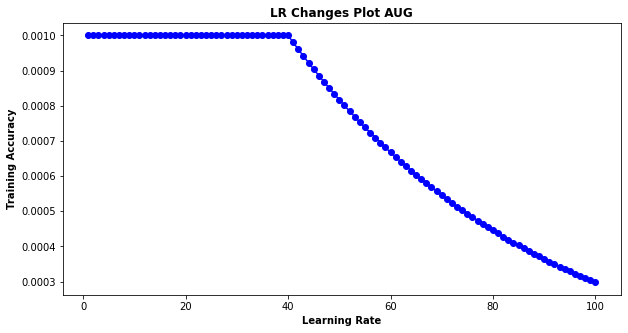

<Figure size 1080x72 with 0 Axes>

test loss from 0 : 2.860276699066162
Output of network:	 tensor([ 0.9099,  0.2361, 15.9452,  0.9099, 12.9478,  5.0477], device='cuda:0')
Target Values:		 tensor([ 0.4659,  0.0000, 18.6898,  0.0000, 10.4096,  6.4987], device='cuda:0') 

loss from this run: 2.860276699066162
Output 3 : 15.945169448852539
Output 5 : 12.94784927368164
Output 6 : 5.047686576843262
Target 3 : 18.689754486083984
Target 5 : 10.409589767456055
Target 6 : 6.4986701011657715
test loss from 1 : 2.023078441619873
Output of network:	 tensor([ 6.6081, -0.1327, 24.4762, 29.4584,  0.7172,  1.3346], device='cuda:0')
Target Values:		 tensor([ 7.0364,  0.0000, 26.5800, 26.9011,  0.0000,  0.6584], device='cuda:0') 

loss from this run: 2.023078441619873
Output 1 : 6.608092308044434
Output 3 : 24.47620964050293
Output 4 : 29.45843505859375
Target 1 : 7.036409854888916
Target 3 : 26.579992294311523
Target 4 : 26.90113067626953
test loss from 2 : 0.8138900995254517
Output of network:	 tensor([ 0.6848,  6.3015,  1.4562,  1.190

test loss from 2 : 4.983999252319336
Output of network:	 tensor([28.9827, 28.9827, 37.2350,  0.3503,  0.2426, -0.0442], device='cuda:0')
Target Values:		 tensor([24.0577, 28.8178, 34.9031,  0.0000,  0.0000,  0.0000], device='cuda:0') 

test loss from 2 : 7.121584892272949
Output of network:	 tensor([ 0.3096,  0.7173,  1.7179, 16.1486,  1.4113,  0.7172], device='cuda:0')
Target Values:		 tensor([ 0.0000,  0.0000,  0.0000, 22.0918,  3.2366,  0.0000], device='cuda:0') 

test loss from 2 : 4.983677864074707
Output of network:	 tensor([ 0.6009,  0.2098,  0.1487,  0.0910,  3.2498, 22.0542], device='cuda:0')
Target Values:		 tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 26.4022], device='cuda:0') 

test loss from 2 : 13.868891716003418
Output of network:	 tensor([ 1.3133, 38.5002,  6.7515, 19.1296,  0.4117, 19.9577], device='cuda:0')
Target Values:		 tensor([ 0.0000, 38.2457,  8.8241, 23.6979,  0.0000, 27.4470], device='cuda:0') 

test loss from 2 : 1.6419838666915894
Output of network

In [48]:
"""
#################################

RETRAINING IMPORTED NETWORKS

#################################
"""
importModelPath = r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new/BCI-ML/Monthly_Data_Summaries_csv/JUN_new3895655/model_BCI_JUN_12-734983188280415.pt"
model = BCIModel()
model.load_state_dict(torch.load(importModelPath))
valid_loss_min = 12.734983

import time
month_list = ["MAR","JUN","JUL","AUG","APR"]
month_list = ["AUG"]
# How many samples per batch to load
batch_size = 6
# For training
n_epochs = 100

for MONTH_NAME in month_list:
    """ 

        LOAD IN DATA 

    """
    month = MONTH_NAME
    os.chdir(startingDir)
    # Number of subprocesses to use for data loading
    # Using advice of 4 workers per GPU
    # Getting errors with any # of workers > 0
    num_workers = 0

    # Proportion of training set to use for validation and testing
    # Note: this will be split in equal halves, one for validation, one for testing
    valid_and_test_proportion = 0.3


    # Define transforms
    transformations = transforms.Compose([transforms.ToTensor()])
    # Define custom datasets, for training and for testing
    # Note: Will be using 10,000 data for testing, 50,000 data for training in future
    masterfileMLLocation = csvfilesMLLocation + r"/populatedGPPs" + month + ".csv"
    BCIDataset = BCIDataset2(masterfileMLLocation)

    # Obtain indices for training, validation and testing datasets
    num_train = len(BCIDataset)         # Number of data points (csv files to be used)
    indices1 = list(range(num_train))   # indices of [0,num_train) to represent data
    np.random.shuffle(indices1)         # Shuffled indices
    # Splitting training from validation/testing
    split1 = int(np.floor(valid_and_test_proportion * num_train))

    train_indices, valid_and_test_indices = indices1[split1:], indices1[:split1]
    # Splitting validation/testing up into their individual groups
    num_valid_test = len(valid_and_test_indices)

    split2 = int(np.floor(0.5 * num_valid_test))
    valid_indices, test_indices = valid_and_test_indices[split2:], valid_and_test_indices[:split2]

    baseSaveLocation = r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new/BCI-ML/Monthly_Data_Summaries_csv"
    os.chdir(baseSaveLocation)
    random.seed()
    summaryInfoDir = month+"_import"+str(random.randint(1,10000))
    os.mkdir(summaryInfoDir)
    # SAVE Indices in case further training is needed, dont want to overfit the data for future retrains
    os.chdir(baseSaveLocation+"/"+summaryInfoDir)
    titlesIndicesData = ["train_indices","valid_indices","test_indices"]
    indicesFile = "indices_data_" + month +".csv"
    with open(indicesFile,'w',newline='') as file:
        writer = csv.writer(file)
        writer.writerow(titlesIndicesData)
        counter = 0
        for train in train_indices:
            if counter >= len(test_indices): 
                test = -1
            else:
                test = test_indices[counter]
            if counter >= len(valid_indices): 
                valid = -1
            else:
                valid = valid_indices[counter]
            counter = counter + 1
            writer.writerow([train,valid,test])
    os.chdir(startingDir)

    # Import indices
    ######################################################
#     os.chdir(r"C:\Users\Peter\Desktop\Thermo_R_Code\FinalThermo\new2\SOLID MONTHS\May")
#     print(os.getcwd())
#     indices_data_MAY = pd.read_csv("indices_data_MAY.csv")
#     print(indices_data_MAY)
#     os.chdir(startingDir)
#     train_indices = indices_data_MAY.train_indices.values
#     old_valid_indices = indices_data_MAY.valid_indices.values
#     old_test_indices = indices_data_MAY.test_indices.values
#     valid_indices = np.delete(old_valid_indices, np.where(old_valid_indices == -1))
#     test_indices = np.delete(old_test_indices, np.where(old_test_indices == -1))
    ######################################################

    # Define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(valid_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    """

        Batch Making

    """
    # Prepare data loaders 
    train_loader = torch.utils.data.DataLoader(BCIDataset, batch_size=batch_size,
                                               sampler=train_sampler, num_workers=num_workers, pin_memory=True)
    valid_loader = torch.utils.data.DataLoader(BCIDataset, batch_size=batch_size,
                                               sampler=valid_sampler, num_workers=num_workers, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(BCIDataset, batch_size=batch_size,
                                               sampler=test_sampler, num_workers=num_workers, pin_memory=True)
    """

        Optimizer, LR schedueler

    """
    # defining the optimizer
    optimizer = optim.Adam(model.parameters(), lr =0.001)
    # defining the scheduler, to handle learning rate changes
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.98)
    #scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr = 0.002, max_lr=0.012,cycle_momentum=False,step_size_up=100)

    # defining loss function
    criterion = nn.MSELoss()
    print(model)
    # check if CUDA is available
    train_on_gpu = torch.cuda.is_available()

    if not train_on_gpu:
        print('CUDA is not available.  Training on CPU ...')
    else:
        print('CUDA is available!  Training on GPU ...')
        model.cuda()


    torch.cuda.empty_cache()
    # Optimization? Best for inputs that do not change in size (this network)
    # "This flag allows you to enable the inbuilt cudnn auto-tuner to find the best algorithm to use for your hardware"
    torch.backends.cudnn.benchmark = True

    # Check that we are on GPU
    for p in model.parameters():
        print(p.device)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if device.type == 'cuda':
        print(torch.cuda.get_device_name(0))
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')
    
    """ TRAINING OF MODEL """
    os.chdir(startingDir)
    #csvfilesMLLocation = r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new2/csvdata10000"
    os.chdir(csvfilesMLLocation)
    # Number of epochs to train the model
    # try 10, 100, 500, 1000
    test_loss = 0.0

    train_loss_vals = []
    valid_loss_vals = []
    epochCounter = []
    lr_vals = []
    time_taken_vals = []
    os.chdir(csvfilesMLLocation)
    for epoch in range(1, n_epochs+1):
        epochCounter.append(epoch)
        lr_vals.append(optimizer.param_groups[0]['lr'])    
        # Measurement of epoch times
        start = time.perf_counter()
        print("Epoch #:", epoch)
        # Keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        ###################
        # train the model #
        ###################
        model.train()
        for data, target in train_loader:
            data, target = data.float(), target.float()
            # Move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # Clear the gradients fo all optimized variables
            optimizer.zero_grad()
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # Fixes shape
            output = torch.flatten(output)
            # Calculate the batch loss
            loss = criterion(output, target)
            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            # Perform a single optimization step (parameter update)
            optimizer.step()
            # Update training loss
            train_loss += loss.item()*data.size(0)

        ######################    
        # validate the model #
        ######################
        model.eval()
        for data, target in valid_loader:
            data, target = data.float(), target.float()
            # Move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # Fixes shape
            output = torch.flatten(output)
            # Calculate the batch loss
            loss = criterion(output, target)
            # Update average validation loss 
            valid_loss += loss.item()*data.size(0)

        # Calculate avearage losses
        train_loss = train_loss/len(train_loader.sampler)
        valid_loss = valid_loss/len(valid_loader.sampler)
        # Update validation loss list
        valid_loss_vals.append(valid_loss)
        # Update training loss list
        train_loss_vals.append(train_loss)

        # Print training/validation stats
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            os.chdir(baseSaveLocation+"/"+summaryInfoDir)
            torch.save(model.state_dict(), 'model_BCI_' + month + '.pt')
            os.chdir(startingDir)
            valid_loss_min = valid_loss

        # save model no matter performance
        os.chdir(baseSaveLocation+"/"+summaryInfoDir)
        torch.save(model.state_dict(), 'model_BCI_unoptim_' + month + '.pt')
        os.chdir(csvfilesMLLocation)

        # End of time check
        print(f'Time: {time.perf_counter()-start}')
        time_taken_vals.append(time.perf_counter()-start)
        # Time of completion
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Current Time =", current_time)
        print("LR:",optimizer.param_groups[0]['lr'])        
        if epoch >= 40:
            scheduler.step()


    print("Operation Complete")
    
    '''
    Save training data
    '''
    os.chdir(baseSaveLocation+"/"+summaryInfoDir)
    titlesTrainingData = ["epoch","train_loss","valid_loss","learning_rate","time_taken"]
    trainFileStats = "training_data_" + month +".csv"
    print(trainFileStats)
    with open(trainFileStats,'w',newline='') as file:
        writer = csv.writer(file)
        writer.writerow(titlesTrainingData)
        for epoch, train, valid, lr, time_t in zip(epochCounter, train_loss_vals, valid_loss_vals, lr_vals, time_taken_vals):
            writer.writerow([epoch,train,valid,lr,time_t])
    os.chdir(startingDir)

    """ 
    CREATION OF TEST RANGE LR PLOT
    """
    fig2=plt.figure(figsize=(10.0, 5.0))
    print(os.getcwd())
    plt.scatter(epochCounter, lr_vals, c="blue")
    plt.plot(epochCounter, lr_vals, c="blue")
    #plt.xlim(0,0.05)
    # plt.ylim(0,100)
    plt.xlabel("Learning Rate", fontweight="semibold")
    plt.ylabel("Training Accuracy", fontweight="semibold")
    plt.title("LR Changes Plot "+month, fontweight="bold")
    plt.figure(figsize=(15,1))
    plt.show()
    my_dpi=96
    fig2.savefig("LR Changes "+month,dpi=my_dpi*5)
    

    """ 
    TESTING OF MODEL 
    """
    # Print out values and images that have large differences in target/value

    # Track test loss
    test_loss = 0.0
    num_predictions = len(test_indices)
    #import time
    # Puts model will notify all your layers that you are in eval mode, that way, 
    # batchnorm or dropout layers will work in eval mode instead of training mode.
    model.eval()
    tarList = list()
    outList = list()
    start = time.perf_counter()
    counter = 0
    os.chdir(csvfilesMLLocation)
    # Iterate over test data
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.float(), target.float()
            # Move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            output = torch.flatten(output)
            # Calculate the batch loss
            loss = criterion(output, target)
            # Update test loss 
            test_loss += loss.item()

            for tar, out in zip(target, output):
                tarList.append(tar.item())
                outList.append(out.item())

            if counter < 10:
                print("test loss from", counter, ":", loss.item())
                print("Output of network:\t", output)
                print("Target Values:\t\t", target,"\n")

            # Example data tensors
            if counter < 2:
                print("loss from this run:", loss.item())
                #print("Output of network:\t", output)
                counterTHIS = 0
                for value in output:
                    counterTHIS += 1
                    if value.item() > 2.0:
                        print("Output", counterTHIS, ":", value.item())
                counterTHIS = 0
                for value in target:
                    counterTHIS += 1
                    if value.item() > 2.0:
                        print("Target", counterTHIS, ":", value.item())
                #print("Target Values:\t", target,"\n")
                counter += 1
                # CHECK LOss HEEWRE



        test_loss = test_loss/len(test_loader.sampler)
        print('Test Loss (mean squared error): {:.6f}\n'.format(test_loss))
    print(f'Time: {time.perf_counter()-start}')


    os.chdir(baseSaveLocation+"/"+summaryInfoDir)
    titlesTestData = ["targets","outputs"]
    test_loss_str =(str(test_loss)).replace(".","-")
    testFileStats = "test_data_" + month + "_"+ test_loss_str +".csv"
    with open(testFileStats,'w',newline='') as file:
        writer = csv.writer(file)
        writer.writerow(titlesTestData)
        for target, output in zip(tarList, outList):
            writer.writerow([target,output])
    os.chdir(startingDir)

In [33]:
"""
#################################

TESTING IMPORTED NETWORKS

#################################
"""

importModelPath = r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new/BCI-ML/Monthly_Data_Summaries_csv/MAR_import1975/model_BCI_MAR.pt"
model = BCIModel()
model.load_state_dict(torch.load(importModelPath))
valid_loss_min = np.Inf 
# defining loss function
criterion = nn.MSELoss()
print(model)
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    model.cuda()
import time
month_list = ["MAR","JUN","JUL","AUG","APR"]
month_list = ["APR"]
# How many samples per batch to load
batch_size = 9
# For training
n_epochs = 100

for MONTH_NAME in month_list:
    """ 

        LOAD IN DATA 

    """
    month = MONTH_NAME
    os.chdir(startingDir)
    # Number of subprocesses to use for data loading
    # Using advice of 4 workers per GPU
    # Getting errors with any # of workers > 0
    num_workers = 0

    # Proportion of training set to use for validation and testing
    # Note: this will be split in equal halves, one for validation, one for testing
    valid_and_test_proportion = 0.3


    # Define transforms
    transformations = transforms.Compose([transforms.ToTensor()])
    # Define custom datasets, for training and for testing
    # Note: Will be using 10,000 data for testing, 50,000 data for training in future
    masterfileMLLocation = csvfilesMLLocation + r"/populatedGPPs" + month + ".csv"
    BCIDataset = BCIDataset2(masterfileMLLocation)

    # Obtain indices for training, validation and testing datasets
    num_train = len(BCIDataset)         # Number of data points (csv files to be used)
    indices1 = list(range(num_train))   # indices of [0,num_train) to represent data
    np.random.shuffle(indices1)         # Shuffled indices
    # Splitting training from validation/testing
    split1 = int(np.floor(valid_and_test_proportion * num_train))

    train_indices, valid_and_test_indices = indices1[split1:], indices1[:split1]
    # Splitting validation/testing up into their individual groups
    num_valid_test = len(valid_and_test_indices)

    split2 = int(np.floor(0.5 * num_valid_test))
    valid_indices, test_indices = valid_and_test_indices[split2:], valid_and_test_indices[:split2]

    baseSaveLocation = r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new/BCI-ML/Monthly_Data_Summaries_csv"
    os.chdir(baseSaveLocation)
    random.seed()
    summaryInfoDir = month+"_TEST_IMPORT"+str(random.randint(1,10000))
    os.mkdir(summaryInfoDir)
    # SAVE Indices in case further training is needed, dont want to overfit the data for future retrains
    os.chdir(baseSaveLocation+"/"+summaryInfoDir)
    titlesIndicesData = ["train_indices","valid_indices","test_indices"]
    indicesFile = "indices_data_" + month +".csv"
    with open(indicesFile,'w',newline='') as file:
        writer = csv.writer(file)
        writer.writerow(titlesIndicesData)
        counter = 0
        for train in train_indices:
            if counter >= len(test_indices): 
                test = -1
            else:
                test = test_indices[counter]
            if counter >= len(valid_indices): 
                valid = -1
            else:
                valid = valid_indices[counter]
            counter = counter + 1
            writer.writerow([train,valid,test])
    os.chdir(startingDir)

    # Import indices
    ######################################################
#     os.chdir(r"C:\Users\Peter\Desktop\Thermo_R_Code\FinalThermo\new2\SOLID MONTHS\May")
#     print(os.getcwd())
#     indices_data_MAY = pd.read_csv("indices_data_MAY.csv")
#     print(indices_data_MAY)
#     os.chdir(startingDir)
#     train_indices = indices_data_MAY.train_indices.values
#     old_valid_indices = indices_data_MAY.valid_indices.values
#     old_test_indices = indices_data_MAY.test_indices.values
#     valid_indices = np.delete(old_valid_indices, np.where(old_valid_indices == -1))
#     test_indices = np.delete(old_test_indices, np.where(old_test_indices == -1))
    ######################################################

    # Define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(valid_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    """

        Batch Making

    """
    # Prepare data loaders 
    train_loader = torch.utils.data.DataLoader(BCIDataset, batch_size=batch_size,
                                               sampler=train_sampler, num_workers=num_workers, pin_memory=True)
    valid_loader = torch.utils.data.DataLoader(BCIDataset, batch_size=batch_size,
                                               sampler=valid_sampler, num_workers=num_workers, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(BCIDataset, batch_size=batch_size,
                                               sampler=test_sampler, num_workers=num_workers, pin_memory=True)
    """ 
    TESTING OF MODEL 
    """
    # Print out values and images that have large differences in target/value

    # Track test loss
    test_loss = 0.0
    num_predictions = len(test_indices)
    #import time
    # Puts model will notify all your layers that you are in eval mode, that way, 
    # batchnorm or dropout layers will work in eval mode instead of training mode.
    model.eval()
    tarList = list()
    outList = list()
    start = time.perf_counter()
    counter = 0
    os.chdir(csvfilesMLLocation)
    # Iterate over test data
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.float(), target.float()
            # Move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            output = torch.flatten(output)
            # Calculate the batch loss
            loss = criterion(output, target)
            # Update test loss 
            test_loss += loss.item()

            for tar, out in zip(target, output):
                tarList.append(tar.item())
                outList.append(out.item())

            if counter < 10:
                print("test loss from", counter, ":", loss.item())
                print("Output of network:\t", output)
                print("Target Values:\t\t", target,"\n")

            # Example data tensors
            if counter < 2:
                print("loss from this run:", loss.item())
                #print("Output of network:\t", output)
                counterTHIS = 0
                for value in output:
                    counterTHIS += 1
                    if value.item() > 2.0:
                        print("Output", counterTHIS, ":", value.item())
                counterTHIS = 0
                for value in target:
                    counterTHIS += 1
                    if value.item() > 2.0:
                        print("Target", counterTHIS, ":", value.item())
                #print("Target Values:\t", target,"\n")
                counter += 1
                # CHECK LOss HEEWRE



        test_loss = test_loss/len(test_loader.sampler)
        print('Test Loss (mean squared error): {:.6f}\n'.format(test_loss))
    print(f'Time: {time.perf_counter()-start}')


    os.chdir(baseSaveLocation+"/"+summaryInfoDir)
    titlesTestData = ["targets","outputs"]
    test_loss_str =(str(test_loss)).replace(".","-")
    testFileStats = "test_data_" + month + "_"+ test_loss_str +".csv"
    with open(testFileStats,'w',newline='') as file:
        writer = csv.writer(file)
        writer.writerow(titlesTestData)
        for target, output in zip(tarList, outList):
            writer.writerow([target,output])
    os.chdir(startingDir)

BCIModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=38400, out_features=100, bias=True)
  (BatchN): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=100, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)
CUDA is available!  Training on GPU ...
Time: 0.0
max is: 40.1815051816256
min is: 22.1157735577469
test loss from 0 : 14.025906562805176
Output of network:	 tensor([ 0.2724,  0.1655,  8.7912,  3.4736,  0.3710, 13.0594, 21.1252,  9.0901,
         0.1385], device='cuda:0')
Target Values:		 tensor([ 0.0000,  0.0000,  0.3840,  0.0000, 

        24.5039], device='cuda:0') 

test loss from 2 : 14.75009822845459
Output of network:	 tensor([ 1.1604,  0.0383,  2.1223, 23.9209, 20.8819,  2.8337,  0.1487,  0.4433,
        10.8057], device='cuda:0')
Target Values:		 tensor([ 0.0000,  0.0000,  0.0000, 25.7359, 14.6601,  5.1002,  0.0000,  0.0000,
        19.7241], device='cuda:0') 

test loss from 2 : 21.959402084350586
Output of network:	 tensor([ 0.7629, 18.3381,  1.0372, 11.2922, 15.0493,  2.8274,  2.8542, 19.1775,
        15.4065], device='cuda:0')
Target Values:		 tensor([ 9.5655, 20.5230,  0.0000,  8.1131, 11.0932, 11.6035,  0.0000, 18.0063,
        16.8224], device='cuda:0') 

test loss from 2 : 24.791147232055664
Output of network:	 tensor([21.5308,  0.4080, 10.9121, 12.5261,  0.4192,  0.4599,  0.3805, 14.7404,
        19.2701], device='cuda:0')
Target Values:		 tensor([24.1144,  0.0000, 17.9379, 15.4478,  0.0000,  0.0000,  0.0000, 11.5316,
        31.4172], device='cuda:0') 

test loss from 2 : 4.0652923583984375
Outpu

         0.0000], device='cuda:0') 

test loss from 2 : 4.580233573913574
Output of network:	 tensor([ 1.7740,  3.8710,  0.4920,  0.4631,  0.0972,  0.3248,  0.8758, 14.0408,
         2.7062], device='cuda:0')
Target Values:		 tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 10.2423,
         0.0000], device='cuda:0') 

test loss from 2 : 15.83836555480957
Output of network:	 tensor([21.3051,  2.4133,  0.2992, 17.6285, 19.5893,  9.1482, 19.1969,  3.3593,
        18.6886], device='cuda:0')
Target Values:		 tensor([16.9714,  2.7433,  0.0000, 21.8422, 20.5210, 17.1686, 24.1601,  0.0000,
        20.8555], device='cuda:0') 

test loss from 2 : 4.935931205749512
Output of network:	 tensor([ 0.4946,  1.7581,  3.0059,  0.5387,  0.4582, 15.3555, 18.3626, 17.6480,
         1.2164], device='cuda:0')
Target Values:		 tensor([ 0.0000,  0.0000,  0.0000,  0.1902,  0.0000, 14.6425, 22.7890, 14.4636,
         0.0000], device='cuda:0') 

test loss from 2 : 13.932581901550293
Output 

         1.0830], device='cuda:0')
Target Values:		 tensor([17.4280,  0.0000,  0.0000,  1.1051,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000], device='cuda:0') 

test loss from 2 : 22.9965763092041
Output of network:	 tensor([ 0.9003,  0.6268,  0.3587,  3.2402, 20.9694,  0.0872, 15.7791,  0.2941,
         0.6628], device='cuda:0')
Target Values:		 tensor([ 0.0000,  1.1777,  0.0000,  0.0000, 25.8341,  0.0000, 13.7909,  0.0000,
        13.6055], device='cuda:0') 

test loss from 2 : 47.92976379394531
Output of network:	 tensor([24.3203,  0.0596,  1.7451, 17.6865,  9.9971, 20.0679,  1.9250, 18.2374,
        17.9907], device='cuda:0')
Target Values:		 tensor([25.5826,  0.0000,  0.0000, 19.2241,  0.0000, 16.9643,  0.8722,  8.1731,
        32.5642], device='cuda:0') 

test loss from 2 : 1.5057485103607178
Output of network:	 tensor([19.6935, 14.0038,  0.6063,  1.7451, 21.2071,  0.3183,  0.4982,  0.4302,
         0.4408], device='cuda:0')
Target Values:		 tensor([17.2145, 13.0153,  0.0

In [41]:

sstt = time.perf_counter()
for num in range(1000000000):
    pass
print(time.perf_counter() - sstt)

37.85008240000025
